In [1]:
!pip install tensorflow==2.17.1 tensorflow-io==0.37.1 tf-keras==2.17.0
!pip install numpy==1.26.4 pandas scikit-learn seaborn matplotlib tensorflow-hub


In [1]:
!pip install --upgrade pip
!pip install tensorflow==2.17.1 tensorflow-io==0.37.1 tf-keras==2.17.0
!pip install numpy==1.26.4 pandas scikit-learn seaborn matplotlib tensorflow-hub
!pip install --upgrade ml_dtypes
!pip uninstall -y jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 86.3 MB/s  0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires ml-dtypes<0.5.0,>=0.3.1, but you have ml-dtypes 0.5.4 which is incompatible.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, but you have tf-keras 2.17.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

@tf.keras.utils.register_keras_serializable(package="Custom")
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config


@tf.keras.utils.register_keras_serializable(package="Custom")
class YAMNetWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model_handle = yamnet_model_handle
        self.yamnet_model = hub.load(yamnet_model_handle)

    def call(self, inputs):
        scores, embeddings, spectrogram = self.yamnet_model(inputs)
        return scores, embeddings, spectrogram

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"yamnet_model_handle": self.yamnet_model_handle})
        return cfg


@tf.keras.utils.register_keras_serializable(package="Custom")
class SplitLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.split(inputs, num_or_size_splits=5, axis=-1)


@tf.keras.utils.register_keras_serializable(package="Custom")
class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=None, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"axis": self.axis})
        return cfg


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [6]:
model = tf.keras.models.load_model(
    "final_model.h5",
    custom_objects={
        "YAMNetWrapperLayer": YAMNetWrapperLayer,
        "ReduceMeanLayer": ReduceMeanLayer,
        "SplitLayer": SplitLayer,
        "SqueezeLayer": SqueezeLayer,
    }
)


In [7]:
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


In [8]:
yamnet_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_handle)


In [10]:
!wget -O Data.zip "https://github.com/ShebinJoseJacob/test/raw/main/Data.zip"
!unzip Data.zip -d /content/datasets/


--2025-12-03 06:17:15--  https://github.com/ShebinJoseJacob/test/raw/main/Data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShebinJoseJacob/test/main/Data.zip [following]
--2025-12-03 06:17:15--  https://raw.githubusercontent.com/ShebinJoseJacob/test/main/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27515302 (26M) [application/zip]
Saving to: ‘Data.zip’

Data.zip            100%[===================>]  26.24M   146MB/s    in 0.2s    

2025-12-03 06:17:16 (146 MB/s) - ‘Data.zip’ saved [27515302/27515302]

Archive:  Data.zip
   creating: /content/datasets/Data/
  inflating: /cont

In [12]:
csv_path = '/content/datasets/Data/meta/metadata.csv'
base_path = '/content/datasets/Data/audio'

df = pd.read_csv(csv_path)

my_classes = ['AS', 'MR', 'MS', 'MVP', 'N']
map_class_to_id = {'AS':0, 'MR':1, 'MS':2, 'MVP':3, 'N':4}

filtered = df[df.foldername.isin(my_classes)]
filtered['target'] = filtered.foldername.apply(lambda x: map_class_to_id[x])
filtered['filename'] = filtered['file name'].apply(lambda x: os.path.join(base_path, x))

# Solo datos de test (fold 5)
test_df = filtered[filtered.fold == 5]


In [19]:
!ls -R /content/datasets/Data


/content/datasets/Data:
audio  meta

/content/datasets/Data/audio:
New_AS_001.wav	New_MR_001.wav	New_MS_001.wav	New_MVP_001.wav  New_N_001.wav
New_AS_002.wav	New_MR_002.wav	New_MS_002.wav	New_MVP_002.wav  New_N_002.wav
New_AS_003.wav	New_MR_003.wav	New_MS_003.wav	New_MVP_003.wav  New_N_003.wav
New_AS_004.wav	New_MR_004.wav	New_MS_004.wav	New_MVP_004.wav  New_N_004.wav
New_AS_005.wav	New_MR_005.wav	New_MS_005.wav	New_MVP_005.wav  New_N_005.wav
New_AS_006.wav	New_MR_006.wav	New_MS_006.wav	New_MVP_006.wav  New_N_006.wav
New_AS_007.wav	New_MR_007.wav	New_MS_007.wav	New_MVP_007.wav  New_N_007.wav
New_AS_008.wav	New_MR_008.wav	New_MS_008.wav	New_MVP_008.wav  New_N_008.wav
New_AS_009.wav	New_MR_009.wav	New_MS_009.wav	New_MVP_009.wav  New_N_009.wav
New_AS_010.wav	New_MR_010.wav	New_MS_010.wav	New_MVP_010.wav  New_N_010.wav
New_AS_011.wav	New_MR_011.wav	New_MS_011.wav	New_MVP_011.wav  New_N_011.wav
New_AS_012.wav	New_MR_012.wav	New_MS_012.wav	New_MVP_012.wav  New_N_012.wav
New_AS_013.wav	New_MR

# **Métricas de desempeño del modelo**


=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

          AS       0.98      0.99      0.99       200
          MR       0.97      0.97      0.97       200
          MS       0.99      0.96      0.98       200
         MVP       0.99      0.98      0.99       200
           N       0.97      1.00      0.99       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Accuracy total: 0.9820


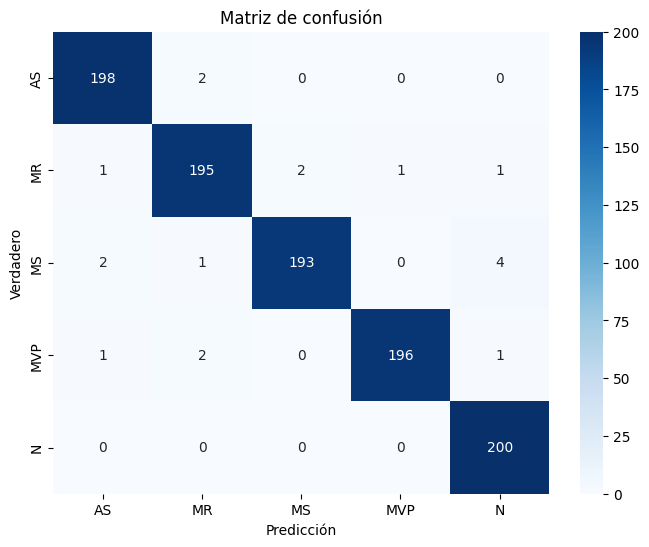

In [20]:
# ==========================================
# 0. IMPORTS
# ==========================================
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


# ==========================================
# 1. CUSTOM LAYERS
# ==========================================
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=None, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis
    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)

class SplitLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.split(inputs, 5, axis=-1)

class YAMNetWrapperLayer(tf.keras.layers.Layer):
    def __init__(self, yamnet_model_handle='https://tfhub.dev/google/yamnet/1', **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model_handle = yamnet_model_handle
        self.yamnet_model = hub.load(yamnet_model_handle)
    def call(self, inputs):
        scores, embeddings, spectrogram = self.yamnet_model(inputs)
        return scores, embeddings, spectrogram


# Registrar custom layers
tf.keras.utils.get_custom_objects().update({
    "Custom>YAMNetWrapperLayer": YAMNetWrapperLayer,
    "Custom>ReduceMeanLayer": ReduceMeanLayer,
    "Custom>SqueezeLayer": SqueezeLayer,
    "Custom>SplitLayer": SplitLayer
})


# ==========================================
# 2. CARGAR MODELO FINAL
# ==========================================
model = tf.keras.models.load_model("final_model.h5")
my_classes = ['AS', 'MR', 'MS', 'MVP', 'N']


# ==========================================
# 3. FUNCIONES AUXILIARES
# ==========================================
def load_audio(path, target_sr=16000):
    audio, sr = librosa.load(path, sr=target_sr, mono=True)
    return audio.astype(np.float32)


# ==========================================
# 4. CARGAR CSV Y CONFIGURAR RUTAS
# ==========================================
csv_path = '/content/datasets/Data/meta/metadata.csv'
base_path = '/content/datasets/Data/audio'

df = pd.read_csv(csv_path)


# ==========================================
# 5. EVALUACIÓN COMPLETA DEL MODELO
# ==========================================
y_true = []
y_pred = []

for idx, row in df.iterrows():

    filename = os.path.join(base_path, row["file name"])  # <-- CORRECTO

    true_label = int(row["foldername"] == "AS") * 0 \
               + int(row["foldername"] == "MR") * 1 \
               + int(row["foldername"] == "MS") * 2 \
               + int(row["foldername"] == "MVP") * 3 \
               + int(row["foldername"] == "N")  * 4

    # cargar audio
    waveform = load_audio(filename)
    waveform_tf = tf.convert_to_tensor(waveform, dtype=tf.float32)

    # el modelo recibe waveform 1D directo
    prediction = model(waveform_tf)
    pred_class = int(tf.argmax(prediction))

    y_true.append(true_label)
    y_pred.append(pred_class)


# ==========================================
# 6. MÉTRICAS
# ==========================================
print("\n=== CLASSIFICATION REPORT ===\n")
print(classification_report(y_true, y_pred, target_names=my_classes))

acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nAccuracy total: {acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=my_classes,
            yticklabels=my_classes,
            cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión")
plt.show()


# **Métricas de calidad de señal**

In [21]:
import numpy as np
import librosa
import scipy.signal as signal

def compute_snr(signal_data):
    power_signal = np.mean(signal_data**2)
    noise = signal_data - signal_data.mean()
    power_noise = np.mean(noise**2)
    return 10 * np.log10(power_signal / power_noise)

def compute_dynamic_range(signal_data):
    max_amp = np.max(np.abs(signal_data))
    min_amp = np.min(np.abs(signal_data)) + 1e-9
    return 20 * np.log10(max_amp / min_amp)

def compute_noise_level(signal_data):
    return np.std(signal_data)

def compute_thd(signal_data, sr):
    N = len(signal_data)
    fft = np.fft.fft(signal_data)
    freqs = np.fft.fftfreq(N, 1/sr)
    magnitude = np.abs(fft)

    # Fundamental: frecuencia con mayor energía
    idx_fundamental = np.argmax(magnitude[:N//2])
    fundamental_power = magnitude[idx_fundamental]

    # Armónicos (2x, 3x, 4x...)
    harmonic_indices = [idx_fundamental * i for i in range(2, 6)
                        if idx_fundamental * i < len(magnitude)]

    harmonic_power = sum(magnitude[h] for h in harmonic_indices)

    thd = harmonic_power / fundamental_power
    return thd

def compute_all_metrics(audio_path):
    x, sr = librosa.load(audio_path, sr=16000)

    snr = compute_snr(x)
    dyn_range = compute_dynamic_range(x)
    noise = compute_noise_level(x)
    thd = compute_thd(x, sr)

    # Filtrado
    hp = signal.butter(4, 20/(sr/2), btype='highpass', output='sos')
    lp = signal.butter(4, 250/(sr/2), btype='lowpass', output='sos')

    filtered = signal.sosfilt(lp, signal.sosfilt(hp, x))
    noise_after = compute_noise_level(filtered)

    return {
        "SNR (dB)": snr,
        "Dynamic Range (dB)": dyn_range,
        "Noise Before Filtering": noise,
        "Noise After Filtering": noise_after,
        "THD": thd
    }

# EJEMPLO:
print(compute_all_metrics("/content/datasets/Data/audio/New_MS_074.wav"))


{'SNR (dB)': 0.00011337906471453607, 'Dynamic Range (dB)': 147.20315270456635, 'Noise Before Filtering': 0.096980065, 'Noise After Filtering': 0.09625030259285487, 'THD': 0.22317502794783453}


In [23]:
import glob
import pandas as pd

all_files = glob.glob("/content/datasets/Data/audio/*.wav")  # <--- CORREGIDO
results = []

for f in all_files:
    try:
        metrics = compute_all_metrics(f)
        metrics["filename"] = f
        results.append(metrics)
    except Exception as e:
        print("Error con:", f, e)

df = pd.DataFrame(results)
df.to_csv("metrics_dataset.csv", index=False)
df.head()


,SNR (dB),Dynamic Range (dB),Noise Before Filtering,Noise After Filtering,THD,filename
0,0.000052,153.731024,0.117846,0.115390,0.763734,/content/datasets/Data/audio/New_MS_058.wav
1,0.000049,161.625177,0.106417,0.105623,0.070882,/content/datasets/Data/audio/New_MS_035.wav
2,0.000078,161.934634,0.145071,0.144246,0.140890,/content/datasets/Data/audio/New_N_005.wav
3,0.000033,150.934286,0.071999,0.066881,0.248605,/content/datasets/Data/audio/New_MR_059.wav
4,0.000039,165.108268,0.075078,0.073927,0.169746,/content/datasets/Data/audio/New_AS_036.wav


In [24]:
def get_class_from_filename(path):
    name = os.path.basename(path).upper()
    if "AS" in name: return "AS"
    if "MR" in name: return "MR"
    if "MS" in name: return "MS"
    if "MVP" in name: return "MVP"
    if "N_" in name or name.startswith("NEW_N"): return "N"
    return "UNKNOWN"


In [25]:
def predict_audio(path):
    x, _ = librosa.load(path, sr=16000)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    pred = model(x)  # tu modelo acepta waveform crudo
    cls = my_classes[int(tf.argmax(pred))]
    return cls


In [26]:
all_files = glob.glob("/content/datasets/Data/audio/*.wav")

results = []

for f in all_files:
    try:
        metrics = compute_all_metrics(f)
        metrics["filename"] = os.path.basename(f)
        metrics["real_class"] = get_class_from_filename(f)
        metrics["predicted_class"] = predict_audio(f)
        metrics["correct"] = metrics["real_class"] == metrics["predicted_class"]

        results.append(metrics)
    except Exception as e:
        print("Error con:", f, "->", str(e))

df = pd.DataFrame(results)
df.to_csv("metrics_with_predictions.csv", index=False)
df.head()


,SNR (dB),Dynamic Range (dB),Noise Before Filtering,Noise After Filtering,THD,filename,real_class,predicted_class,correct
0,0.000052,153.731024,0.117846,0.115390,0.763734,New_MS_058.wav,MS,MS,True
1,0.000049,161.625177,0.106417,0.105623,0.070882,New_MS_035.wav,MS,MS,True
2,0.000078,161.934634,0.145071,0.144246,0.140890,New_N_005.wav,N,N,True
3,0.000033,150.934286,0.071999,0.066881,0.248605,New_MR_059.wav,MR,MR,True
4,0.000039,165.108268,0.075078,0.073927,0.169746,New_AS_036.wav,AS,AS,True


### **THD por clase real**

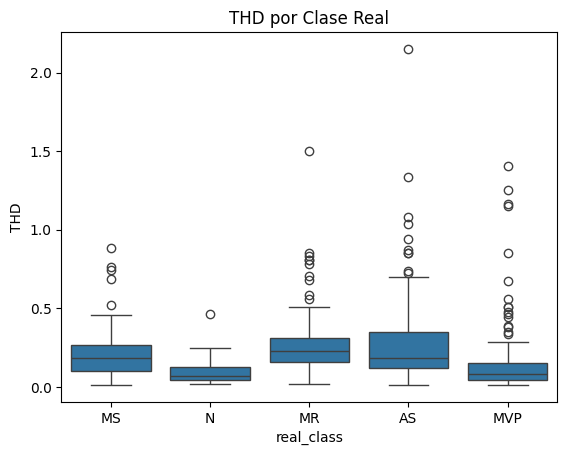

In [27]:
sns.boxplot(data=df, x="real_class", y="THD")
plt.title("THD por Clase Real")
plt.show()


### **SNR por clase real**

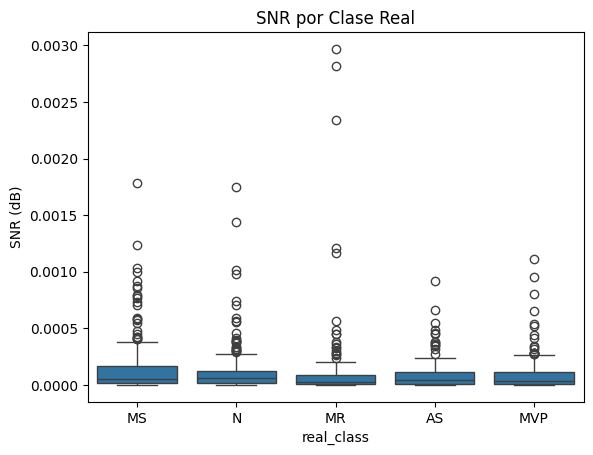

In [28]:
sns.boxplot(data=df, x="real_class", y="SNR (dB)")
plt.title("SNR por Clase Real")
plt.show()


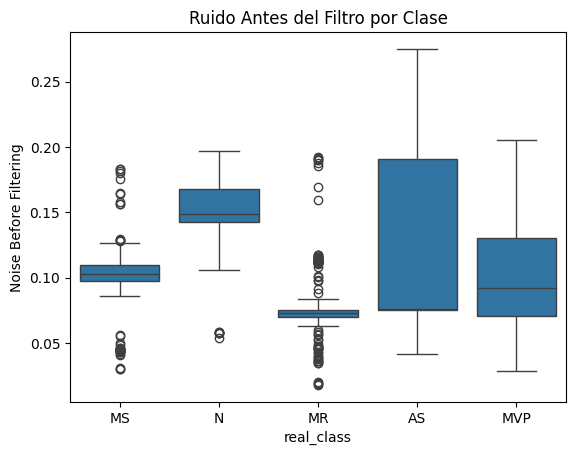

In [29]:
sns.boxplot(data=df, x="real_class", y="Noise Before Filtering")
plt.title("Ruido Antes del Filtro por Clase")
plt.show()


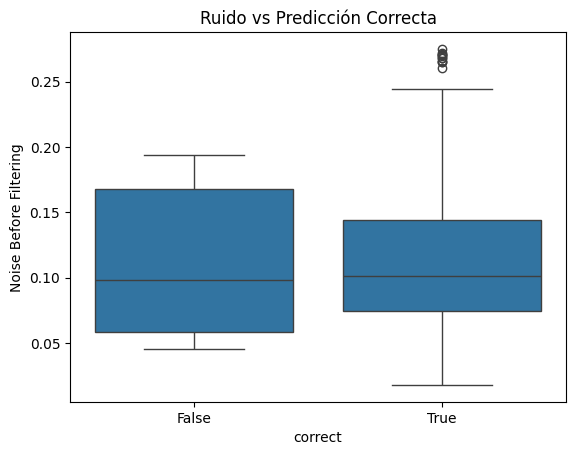

In [30]:
sns.boxplot(data=df, x="correct", y="Noise Before Filtering")
plt.title("Ruido vs Predicción Correcta")
plt.show()


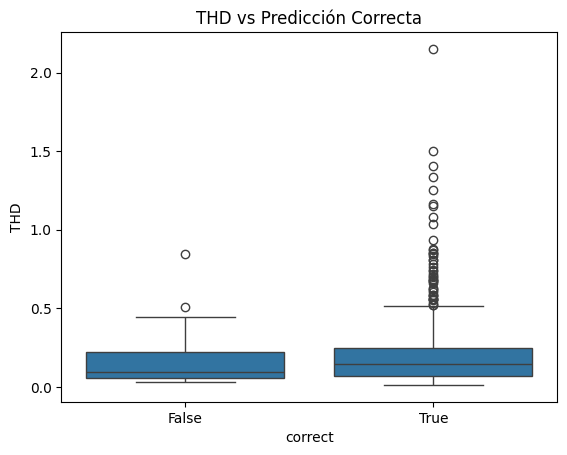

In [31]:
sns.boxplot(data=df, x="correct", y="THD")
plt.title("THD vs Predicción Correcta")
plt.show()

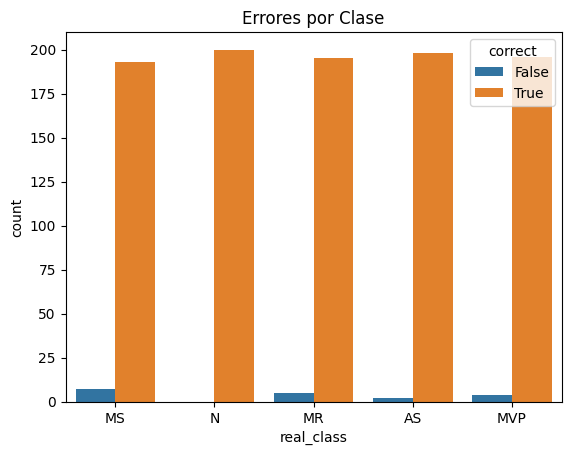

In [32]:
sns.countplot(data=df, x="real_class", hue="correct")
plt.title("Errores por Clase")
plt.show()
